In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import glob
import pickle
import csv

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, Attention, LayerNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Bidirectional, Masking, Concatenate

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [73]:
data_csv_path = '/home/smrutibiswal/Research/Dataset/labels/edited'

train_df = pd.read_csv(os.path.join(data_csv_path, 'train_split.csv'))
train_df = train_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

test_df = pd.read_csv(os.path.join(data_csv_path, 'dev_split.csv'))
test_df = test_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

print(f"Train set: {train_df.shape[0]} samples, Test set: {test_df.shape[0]} samples")
print("Training Samples: ")
print(train_df.head())
print("Testing Samples: ")
print(test_df.head())

Train set: 148 samples, Test set: 48 samples
Training Samples: 
   Participant_ID   Gender  PHQ_Binary  PHQ_Score
0             302     male           0          4
1             303   female           0          0
2             304   female           0          6
3             305     male           0          7
4             307  female            0          4
Testing Samples: 
   Participant_ID  Gender  PHQ_Binary  PHQ_Score
0             300    male           0          2
1             301    male           0          3
2             306  female           0          0
3             317    male           0          8
4             320  female           0         11


In [74]:
train_audio_path = '/home/smrutibiswal/Research/Dataset/data/train/audios'
test_audio_path = '/home/smrutibiswal/Research/Dataset/data/validation/audios'
train_trans_path = '/home/smrutibiswal/Research/Dataset/data/train/transcripts'
test_trans_path = '/home/smrutibiswal/Research/Dataset/data/validation/transcripts'
train_txt_path = '/home/smrutibiswal/Research/TextOnly/train'
test_txt_path = '/home/smrutibiswal/Research/TextOnly/test'

train_df['Audio_Path'] = ''
train_df['Transcript_Path'] = ''
train_df['Text_Path'] = ''
test_df['Audio_Path'] = ''
test_df['Transcript_Path'] = ''
test_df['Text_Path'] = ''


for i in range(train_df.shape[0]):
    audio_file = str(train_df['Participant_ID'][i]) + '_AUDIO.wav'
    train_df['Audio_Path'][i] = os.path.join(train_audio_path, audio_file)
    transcript_file = str(train_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    train_df['Transcript_Path'][i] = os.path.join(train_trans_path, transcript_file)
    txt_file = str(train_df['Participant_ID'][i])+'.txt'
    train_df['Text_Path'][i] = os.path.join(train_txt_path, txt_file)
    
    
for i in range(len(test_df)):
    audio_file = str(test_df['Participant_ID'][i]) + '_AUDIO.wav'
    test_df['Audio_Path'][i] = os.path.join(test_audio_path, audio_file)
    transcript_file = str(test_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    test_df['Transcript_Path'][i] = os.path.join(test_trans_path, transcript_file)
    txt_file = str(test_df['Participant_ID'][i])+'.txt'
    test_df['Text_Path'][i] = os.path.join(test_txt_path, txt_file)
    
train_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path
0,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...
1,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...
2,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...
3,305,male,0,7,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/305...
4,307,female,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/307...


In [75]:
train_df['Text'] = ''
train_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/train'

for i in range(len(train_df)):
    file_name = str(train_df['Participant_ID'][i]) + '.txt'
    with open(os.path.join(train_conv_txt_path, file_name), 'r') as f:
        text = f.read()
        train_df['Text'][i] = text
        
train_df.head()

test_df['Text'] = ''
test_conv_txt_path = '/home/smrutibiswal/Research/TextOnly/test'

for i in range(len(test_df)):
    file_name = str(test_df['Participant_ID'][i]) + '.txt'
    with open(os.path.join(test_conv_txt_path, file_name), 'r') as f:
        text = f.read()
        test_df['Text'][i] = text
        
test_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...
2,306,female,0,0,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/306.txt,okay looks like we're good. Let's move around ...
3,317,male,0,8,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/317.txt,equipment okay how was okay thanks are you ...
4,320,female,0,11,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/320.txt,perfect okay and okay and then I will let you...


In [76]:
df = pd.concat([train_df, test_df], axis=0)
df = df.sort_values(by=['Participant_ID'])
df = df.reset_index(drop=True)
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...


In [77]:
audio_features_path = '/home/smrutibiswal/Research/SpeechOnly/features'

df['Audio_Features'] = ''

for i in range(len(df)):
    idx = df['Participant_ID'][i]
    feature_file = os.path.join(audio_features_path, str(idx) + '_features.pkl')
    if os.path.exists(feature_file):
        with open(feature_file, 'rb') as f:
            features = pickle.load(f)
        df['Audio_Features'][i] = features
    else:
        print(f"Feature file not found for Participant_ID: {idx}")
        
df.head()

    

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text,Audio_Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378..."


In [78]:
prosodic_features_path = '/home/smrutibiswal/Research/ProsodyOnly/Prosodic_Features'
df['Prosodic_Features'] = ''

for i in range(len(df)):
    feature_file = os.path.join(prosodic_features_path, str(df['Participant_ID'][i]) + '_features.pkl')
    if os.path.exists(feature_file):
        with open(feature_file, 'rb') as f:
            features = pickle.load(f)
        df['Prosodic_Features'][i] = features
    else:
        print(f"Prosodic feature file not found for Participant_ID: {df['Participant_ID'][i]}")
        
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text,Audio_Features,Prosodic_Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510..."


In [79]:
def aggregate_features(features, window_size=4):
    features = np.array(features, dtype=np.float64)  # force to float array
    # Replace None with NaN
    features = np.where(features == None, np.nan, features)  
    # Compute mean ignoring NaNs
    n = len(features)
    return np.nanmean(
        features[:n - n % window_size].reshape(-1, window_size, features.shape[1]),
        axis=1
    )

In [80]:
# reduce the size of prosodic features
# def aggregate_features(features, window_size=4):
#     n = len(features)
#     return np.mean(features[:n - n % window_size].reshape(-1, window_size, features.shape[1]), axis=1)

pros_feat = df['Prosodic_Features'][0]

prrrr = aggregate_features(pros_feat, window_size=4)
print(f"Original Prosodic Features Shape: {pros_feat.shape}, Aggregated Shape: {prrrr.shape}")

Original Prosodic Features Shape: (12962, 16), Aggregated Shape: (3240, 16)


In [81]:
df['reduced_Prosodic_Features'] = ''

for i in range(len(df)):
    feat = df['Prosodic_Features'][i]
    reduced_feat = aggregate_features(feat, window_size=4)
    df['reduced_Prosodic_Features'][i] = reduced_feat
    print(f"Participant {df['Participant_ID'][i]}: Original Shape: {feat.shape}, Reduced Shape: {reduced_feat.shape}")
    
print(type(df['reduced_Prosodic_Features'][0]))
    

Participant 300: Original Shape: (12962, 16), Reduced Shape: (3240, 16)
Participant 301: Original Shape: (16470, 16), Reduced Shape: (4117, 16)
Participant 302: Original Shape: (15168, 16), Reduced Shape: (3792, 16)
Participant 303: Original Shape: (19698, 16), Reduced Shape: (4924, 16)
Participant 304: Original Shape: (15844, 16), Reduced Shape: (3961, 16)
Participant 305: Original Shape: (34072, 16), Reduced Shape: (8518, 16)
Participant 306: Original Shape: (17154, 16), Reduced Shape: (4288, 16)
Participant 307: Original Shape: (24768, 16), Reduced Shape: (6192, 16)
Participant 308: Original Shape: (17344, 16), Reduced Shape: (4336, 16)
Participant 309: Original Shape: (14108, 16), Reduced Shape: (3527, 16)
Participant 310: Original Shape: (16890, 16), Reduced Shape: (4222, 16)
Participant 311: Original Shape: (15704, 16), Reduced Shape: (3926, 16)
Participant 312: Original Shape: (15792, 16), Reduced Shape: (3948, 16)
Participant 313: Original Shape: (15068, 16), Reduced Shape: (37

In [82]:
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text,Audio_Features,Prosodic_Features,reduced_Prosodic_Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."


## Data Imbalance

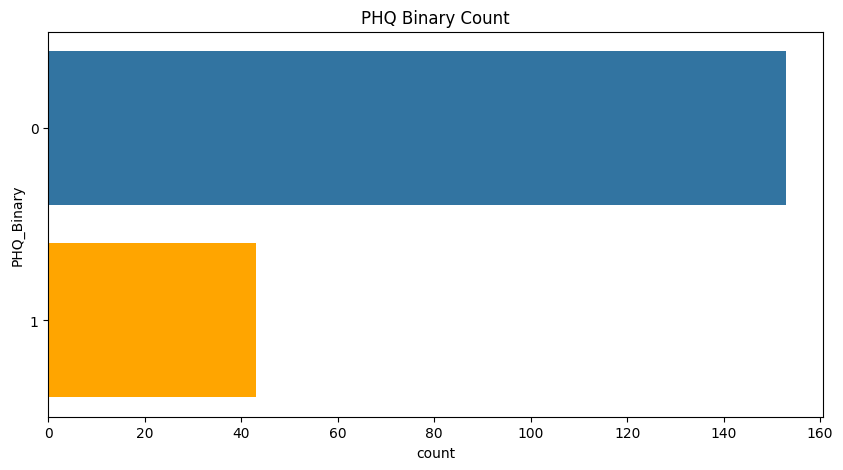

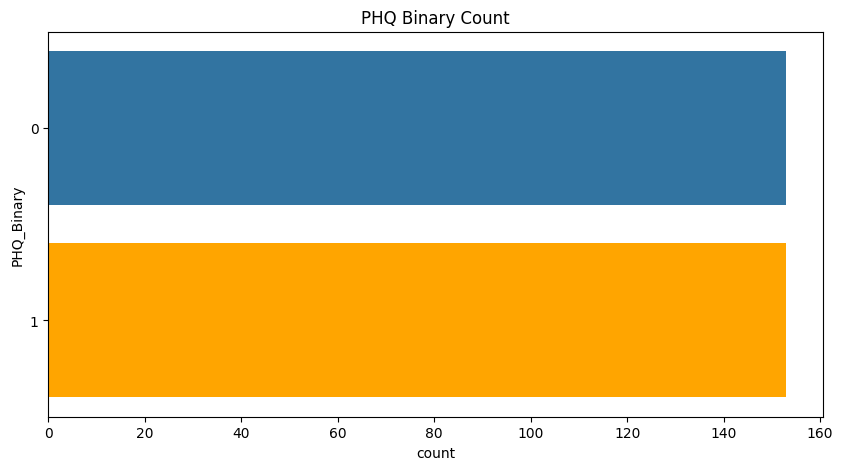

In [83]:
plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()

depressed = df[df['PHQ_Binary'] == 1]
not_depressed = df[df['PHQ_Binary'] == 0]

# not_depressed = not_depressed.sample(n=len(depressed), random_state=44)
depressed = depressed.sample(n=len(not_depressed), random_state=44, replace=True)

df = pd.concat([depressed, not_depressed], axis=0).reset_index(drop=True)
df = df.sample(frac=1, random_state=44).reset_index(drop=True)

plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()


In [84]:
# sort by Participant_ID
df = df.sort_values(by='Participant_ID')
df = df.reset_index(drop=True)

df.head()


,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript_Path,Text_Path,Text,Audio_Features,Prosodic_Features,reduced_Prosodic_Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/300.txt,so I'm going to interview in Spanish okay g...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/TextOnly/test/301.txt,yeah there's also on Craigslist so that's why ...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/302...,just move around a little bit when you're fin...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/303...,wow okay when you're finished when she's done...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/TextOnly/train/304...,so we'll just move around a little bit tonight...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378...","[[0.4237957357199261, 949.0, 0.0, nan, -60.510...","[[0.4237957357199261, 949.0, 0.0, nan, -61.048..."


In [85]:
print(f"Final Dataset: {df.shape[0]} samples")

Final Dataset: 306 samples


# Text Modeling

In [86]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(df['Text'], df['PHQ_Binary'], test_size=0.2, random_state=44)
print(X_train_text.shape, X_test_text.shape, y_train_text.shape, y_test_text.shape)

# X_text = X_train_text   

(244,) (62,) (244,) (62,)


In [87]:
def count_num_words(text):
    """
    Count the number of words in a text.

    Args:
        text (str): The text to count the number of words in.

    Returns:
        int: The number of words in the text.
    """
    return len(text.split())

In [88]:
df['Text_length'] = df['Text'].apply(count_num_words)
df.head()

# find min and max text length
print(df['Text_length'].min())
print(df['Text_length'].max())

average = df['Text_length'].mean()
print(average)

max_len = int(average)
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
vocab_size = 100000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train_text)

word_index = tokenizer.word_index
total_words = len(word_index) + 1

total_words


244
4611
1440.6176470588234


8245

In [89]:
training_sequences = tokenizer.texts_to_sequences(X_train_text)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test_text)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

print('Shape of training padded:', training_padded.shape)
print('Shape of testing padded:', testing_padded.shape)

Shape of training padded: (244, 1440)
Shape of testing padded: (62, 1440)


In [90]:
vocab_size = total_words
embedding_dim = 16
# max_len = df['Text_length'].max()
n_lstm = 128
drop = 0.3

In [91]:
text_input = Input(shape=(max_len,), name="text_input")
x_text = Embedding(vocab_size, embedding_dim, input_length=max_len)(text_input)
x_text = Bidirectional(LSTM(n_lstm, return_sequences=False))(x_text)
x_text = Dropout(drop)(x_text)

## Audio Features

In [92]:
if type(df['Audio_Features'].iloc[0]) == str:
    df['Features'] = df['Features'].apply(lambda x: np.fromstring(x.replace('\n', ' ').replace('[', '').replace(']', ''), sep=' '))
    
X = np.stack(df['Audio_Features'].values)
print(X.shape)
X = X.reshape(-1,16,16)
y = df['PHQ_Binary'].values
print(X.shape, y.shape)

(306, 1, 1, 256)
(306, 16, 16) (306,)


In [93]:
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(X, y, test_size=0.2, random_state=44)
print (X_train_audio.shape, X_test_audio.shape, y_train_audio.shape, y_test_audio.shape)

# X_audio = X_train_audio

(244, 16, 16) (62, 16, 16) (244,) (62,)


In [94]:
# ---------- Acoustic branch (GRU) ----------
n_timesteps = 16  # Example: number of time frames
n_features = 16    # Example: features per frame

audio_input = Input(shape=(n_timesteps, n_features), name="audio_input")
x_audio = Masking(mask_value=0.0)(audio_input)
x_audio = GRU(64, return_sequences=False)(x_audio)
x_audio = Dropout(0.3)(x_audio)

## Prosodic Features

In [95]:
X = [np.nan_to_num(arr.astype(float), nan=0.0) for arr in df['reduced_Prosodic_Features']]
y = df['PHQ_Binary'].astype(int).values

print(len(X), X[0].shape, y.shape)

306 (3240, 16) (306,)


In [96]:
max_len = max(seq.shape[0] for seq in X)  # longest sequence length
n_features = X[0].shape[1]
print(f"Max length: {max_len}, Number of features: {n_features}")

lengths = [seq.shape[0] for seq in X]
max_len = int(np.mean(lengths))  # round down to int
print(f"Average length: {max_len}")

# minium length for padding
min_len = min(lengths)
print(f"Minimum length: {min_len}")

X_pad = pad_sequences(X, maxlen=min_len, dtype='float32', padding='post')
print("Data shape:", X_pad.shape)

X_train_prosodic, X_test_prosodic, y_train_prosodic, y_test_prosodic = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)
print("Train set shape:", X_train_prosodic.shape, y_train_prosodic.shape)
print("Test set shape:", X_test_prosodic.shape, y_test_prosodic.shape)

Max length: 9829, Number of features: 16
Average length: 4902
Minimum length: 2072
Data shape: (306, 2072, 16)
Train set shape: (244, 2072, 16) (244,)
Test set shape: (62, 2072, 16) (62,)


In [97]:
prosodic_input = Input(shape=(2072, 16), name="prosodic_input")  # (timesteps=2072, features=16)
x_prosodic = Masking(mask_value=0.0)(prosodic_input)
x_prosodic = GRU(64, return_sequences=False)(x_prosodic)
x_prosodic = Dropout(0.3)(x_prosodic)

In [98]:
print(X_train_audio.shape, X_train_prosodic.shape)

print(f"Audio input shape: {X_train_audio.shape}, Prosodic input shape: {X_train_prosodic.shape}")

(244, 16, 16) (244, 2072, 16)
Audio input shape: (244, 16, 16), Prosodic input shape: (244, 2072, 16)


# Fusion

In [99]:
x = Concatenate()([x_text, x_audio, x_prosodic])
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

In [100]:
model = Model(inputs=[text_input, audio_input, prosodic_input], outputs=output)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 16, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prosodic_input      │ (None, 2072, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 1440)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 16, 16)    │          0 │ audio_input[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 2072, 16)  │          0 │ prosodic_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1440, 16)  │    131,920 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, 16, 16)    │          0 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, 16)        │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_6 (Masking) │ (None, 2072, 16)  │          0 │ prosodic_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_6 (Any)         │ (None, 2072)      │          0 │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    148,480 │ embedding_3[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 64)        │     15,744 │ masking_5[0][0],  │
│                     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ (None, 64)        │     15,744 │ masking_6[0][0],  │
│                     │                   │            │ any_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ bidirectional_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ gru_5[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ gru_6[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 384)       │          0 │ dropout_13[0][0], │
│ (Concatenate)       │                   │            │ dropout_14[0][0], │
│                     │                   │            │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │     24,640 │ concatenate_3[0]

 Total params: 338,674 (1.29 MB)

 Trainable params: 338,674 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(   [training_padded, X_train_audio, X_train_prosodic], 
    tf.keras.utils.to_categorical(y_train_audio, num_classes=2), 
    validation_data=([testing_padded, X_test_audio, X_test_prosodic], tf.keras.utils.to_categorical(y_test_audio, num_classes=2)),
    epochs=50, 
    batch_size=32, 
    callbacks=[early_stopping]
)

Epoch 1/50


2025-08-13 01:01:20.422853: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5000 - loss: 0.7453 - val_accuracy: 0.5161 - val_loss: 0.6962
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5697 - loss: 0.6886 - val_accuracy: 0.4839 - val_loss: 0.6956
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4590 - loss: 0.7136 - val_accuracy: 0.4839 - val_loss: 0.6993
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4672 - loss: 0.7055 - val_accuracy: 0.5000 - val_loss: 0.6892
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5410 - loss: 0.6937 - val_accuracy: 0.5161 - val_loss: 0.6938
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4959 - loss: 0.7002 - val_accuracy: 0.6129 - val_loss: 0.6886
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5451 - loss: 0.6837 - val_accuracy: 0.5806 - val_loss: 0.6779
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6721 - loss: 0.6417 - val_accuracy: 0.6774 - val_loss: 0.6500
Epoch 9/50
8/8 ━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step - accuracy: 0.6774 - loss: 0.6500


Test loss: 0.650048017501831, Test accuracy: 0.6774193644523621


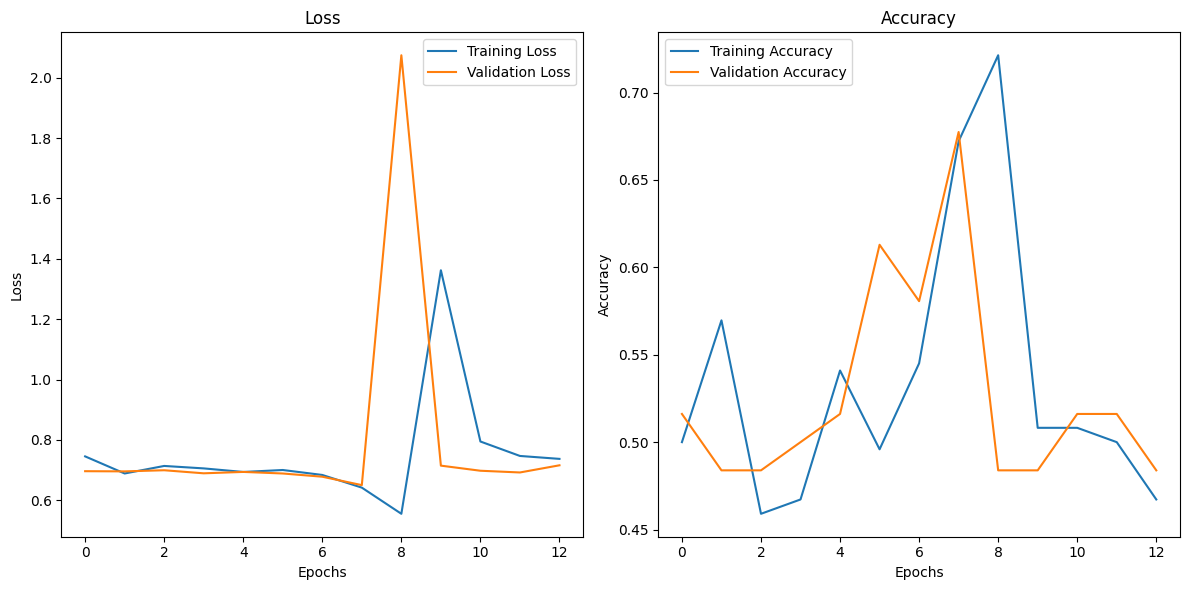

In [102]:
# evaluate the model
test_loss, test_accuracy = model.evaluate([testing_padded, X_test_audio, X_test_prosodic], tf.keras.utils.to_categorical(y_test_audio, num_classes=2))
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

# Save the model
model.save('/home/smrutibiswal/Research/SpeechTextProsody/model.h5')

# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()  